In [1]:
from bit_config import *
from utils import *
import torch
from torchsummary import summary
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

model = resmlp_24(pretrained=True)
qmodel = q_resmlp24(model, full_precision_flag=True)

mdict = model.state_dict()
qmdict = qmodel.state_dict()

In [ ]:
plt.rcParams["figure.figsize"] = [20, 5]

plt.rcParams["figure.autolayout"] = True

layer_name = 'layer0.gamma_2.weight'
print("(min, max):  ", (qmdict[layer_name].min(), qmdict[layer_name].max()))
print("(std, mean): ", torch.std_mean(qmdict[layer_name], unbiased=False))
ax = sns.heatmap(qmdict[layer_name])
ax.plot()


In [ ]:
layer_name = 'layer1.gamma_1.weight'
print("(min, max):  ", (qmdict[layer_name].min(), qmdict[layer_name].max()))
print("(std, mean): ", torch.std_mean(qmdict[layer_name], unbiased=False))
ax = sns.heatmap(qmdict[layer_name])
ax.plot()


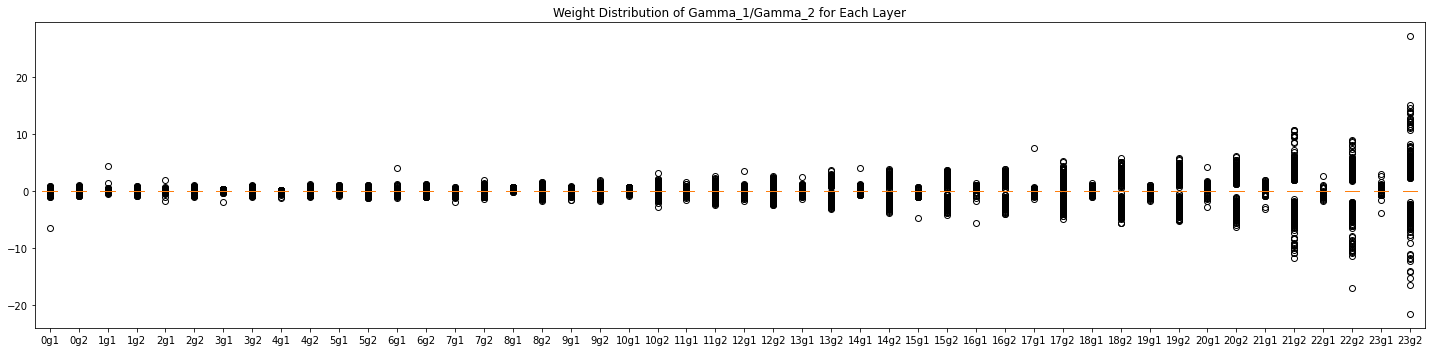

In [21]:
plt.title('Weight Distribution of Gamma_1/Gamma_2 for Each Layer')
plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams["figure.autolayout"] = True

data = []
labels = []
for i in range(0, 24):
  layer1_name = f'layer{i}.gamma_1.weight'
  data1 = qmdict[layer1_name].detach().numpy().flatten()

  layer2_name = f'layer{i}.gamma_2.weight'
  data2 = qmdict[layer2_name].detach().numpy().flatten()

  # data = np.concatenate([[data1], [data2]], axis=0)
  data.append(data1)
  data.append(data2)
  labels.append(f'{i}g1')
  labels.append(f'{i}g2')
  
# Creating plot
bp = plt.boxplot(data, labels=labels)
plt.show()

In [4]:
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output[0].detach()
    return hook

getattr(qmodel, 'quant_patch').norm.register_forward_hook(get_activation('in'))
for i in range(0, 24):
  layer_name = f'layer{i}'
  layer1_name = f'{i}g1'
  layer2_name = f'{i}g2'
  getattr(qmodel, layer_name).gamma_1.register_forward_hook(get_activation(layer1_name))
  getattr(qmodel, layer_name).gamma_2.register_forward_hook(get_activation(layer2_name))

x = torch.Tensor(np.random.rand(1, 3, 224, 224))
output = qmodel(x)

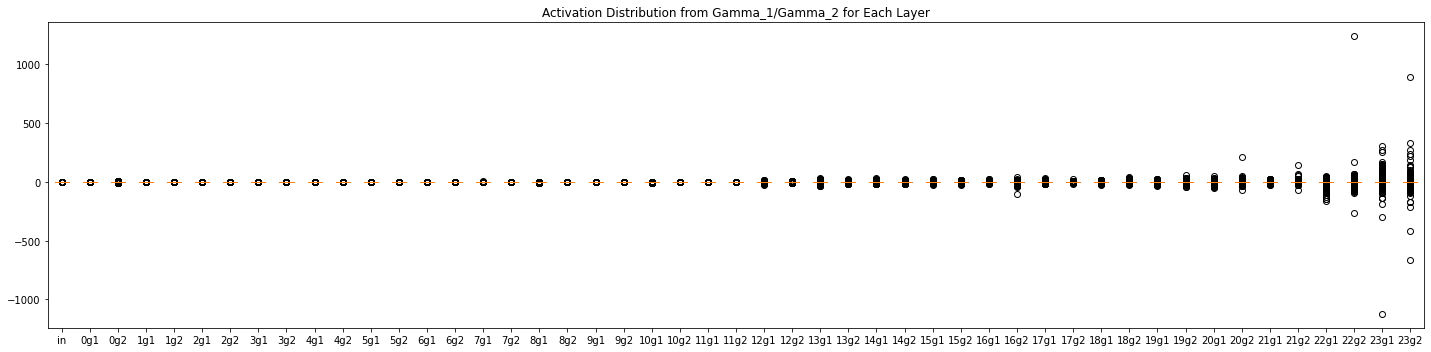

In [26]:
plt.title('Activation Distribution from Gamma_1/Gamma_2 for Each Layer')
plt.rcParams["figure.figsize"] = [20, 5]
# plt.rcParams["figure.figsize"] = [5, 5]

plt.rcParams["figure.autolayout"] = True

data = []
labels = []
for name in list(activations):
  labels.append(name)
  # print(activations[name].shape)
  data.append(activations[name][0].flatten())
  
# Creating plot
bp = plt.boxplot(data, labels=labels)
plt.show()

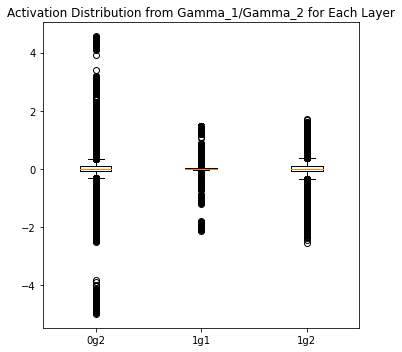

In [23]:
plt.title('Activation Distribution from Gamma_1/Gamma_2 for Each Layer')
# plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams["figure.figsize"] = [5, 5]

plt.rcParams["figure.autolayout"] = True

data = []
labels = []
for name in list(activations)[2:5]:
  labels.append(name)
  # print(activations[name].shape)
  data.append(activations[name][0].flatten())
  
# Creating plot
bp = plt.boxplot(data, labels=labels)
plt.show()

In [2]:
for a in qmodel.named_modules():
  print(a)

('', Q_ResMLP24(
  (quant_input): QuantAct(activation_bit=4, full_precision_flag=True, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.00)
  (quant_patch): Q_PatchEmbed(
    (proj): (QuantConv2d(
      (conv): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    ) weight_bit=4, bias_bit=32, full_precision_flag=True, quant_mode=symmetric)
    (quant_act_int32): QuantAct(activation_bit=4, full_precision_flag=True, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.00)
    (norm): Identity()
  )
  (layer0): Q_Layer(
    (quant_act): QuantAct(activation_bit=4, full_precision_flag=True, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.00)
    (norm1): (QuantLinear() weight_bit=4, bias_bit=32, full_precision_flag=True, quantize_fn=symmetric)
    (quant_act1): QuantAct(activation_bit=4, full_precision_flag=True, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.00)
    (attn): (QuantLinear() weight_bit=4, bias_bit=32, full_precision_flag=True, quantize_fn=symmetric)
    (quant_act2): QuantAct(